## EnergyPlus + Python + Eppy
This script is an intro to the Energyplus + Eppy <br>
It demonestrates how to automate the manipulation and running energyplus IDF files using Eppy and python scripts <br>
Prepared by: Pedram Nojedehi <br>
Created on: 18/07/2025

# Initialization and Setup
Introduce EnergyPlus automation and get started with loading the model:

In [5]:
pip install eppy

In [32]:
from eppy.modeleditor import IDF
import os

idd_path = r"C:\EnergyPlusV24-1-0\Energy+.idd"
idf_path = r"Shoebox.idf"
epw_path = r"ON_OTTAWA-INTL-ONT_716280_19.epw"

output_dir = "eppy_output"
os.makedirs(output_dir, exist_ok=True)

IDF.setiddname(idd_path) # Tells Eppy which IDD file to use. This step must be done before loading any IDF.
idf = IDF(idf_path, epw_path)

Once we've set up our model and weather file, we can trigger the EnergyPlus simulation directly from Python.

This executes the model with current settings and writes results into the defined output directory.

In [54]:
idf.run()


C:\EnergyPlusV24-1-0\energyplus.exe --weather G:\Other computers\My Laptop (1)\Dissemination\eppy_API_workshop\EnergyPlus-python-EMS-main\ON_OTTAWA-INTL-ONT_716280_19.epw --output-directory G:\Other computers\My Laptop (1)\Dissemination\eppy_API_workshop\EnergyPlus-python-EMS-main --idd C:\EnergyPlusV24-1-0\Energy+.idd --expandobjects G:\Other computers\My Laptop (1)\Dissemination\eppy_API_workshop\EnergyPlus-python-EMS-main\Shoebox_8ba94c.idf



#### Optional: Now let us try to change the idd file. Eppy should not let you do this and should raise an exception.

In [2]:
from eppy.modeleditor import IDF
import os

idd_path = r"C:\EnergyPlusV23-1-0\Energy+.idd"
idf_path = r"Shoebox.idf"
epw_path = r"ON_OTTAWA-INTL-ONT_716280_19.epw"

output_dir = "eppy_output"
os.makedirs(output_dir, exist_ok=True)

IDF.setiddname(idd_path)
idf = IDF(idf_path, epw_path)

IDDAlreadySetError: IDD file is set to: C:\EnergyPlusV24-1-0\Energy+.idd

# Inspect different IDF objects used in the model

* Put the name of the object you'd like to look at in brackets:

            filename.idfobjects['OBJECTNAME']

In [2]:
# type: idf_msequence.Idf_MSequence: subclass of Python’s 'UserList': it holds a sequence of EnergyPlus objects of the same type
idf.idfobjects["BuildingSurface:Detailed"] 

# type: bunch_subclass.EpBunch: It behaves like both a Python object and a dictionary, allowing flexible attribute access.
# idf.idfobjects["BuildingSurface:Detailed"][0] 

[
BuildingSurface:Detailed,
    324F0D,                   !- Name
    Floor,                    !- Surface Type
    Exterior Floor,           !- Construction Name
    Zone1,                    !- Zone Name
    ,                         !- Space Name
    Ground,                   !- Outside Boundary Condition
    ,                         !- Outside Boundary Condition Object
    NoSun,                    !- Sun Exposure
    NoWind,                   !- Wind Exposure
    ,                         !- View Factor to Ground
    4,                        !- Number of Vertices
    4,                        !- Vertex 1 Xcoordinate
    4,                        !- Vertex 1 Ycoordinate
    0,                        !- Vertex 1 Zcoordinate
    4,                        !- Vertex 2 Xcoordinate
    0,                        !- Vertex 2 Ycoordinate
    0,                        !- Vertex 2 Zcoordinate
    0,                        !- Vertex 3 Xcoordinate
    0,                        !- Vertex 3 Yco

How about when a field has two words like “Construction Name”?
* put an underscore where there is a space: Construction_Name

In [8]:
idf.idfobjects["BuildingSurface:Detailed"][0].Construction_Name

'Exterior Floor'

In [9]:
idf.idfobjects["BuildingSurface:Detailed"][0].Zone_Name

'Zone1'

In [10]:
for surface in idf.idfobjects["BuildingSurface:Detailed"]:
    print(surface.Construction_Name)

Exterior Floor
Exterior Wall
Exterior Roof
Exterior Wall
Exterior Wall
Exterior Wall


#### Tip: 

eppy is case sensitive except when calling IDF object classes/types: 

1. You can choose either of these: Construction vs. CONSTRUCTION

2. But you cannot use Outside_layer instead of Outside_Layer

In [3]:
idf.idfobjects["Construction"]

# idf.idfobjects["CONSTRUCTION"]

# idf.idfobjects["Construction"][0].Outside_Layer

# idf.idfobjects["Construction"][0].Outside_layer

[
Construction,
    Exterior Floor,           !- Name
    I02 50mm insulation board,    !- Outside Layer
    M15 200mm heavyweight concrete;    !- Layer 2
, 
Construction,
    Interior Floor,           !- Name
    F16 Acoustic tile,        !- Outside Layer
    F05 Ceiling air space resistance,    !- Layer 2
    M11 100mm lightweight concrete;    !- Layer 3
, 
Construction,
    Exterior Wall,            !- Name
    M01 100mm brick,          !- Outside Layer
    M15 200mm heavyweight concrete,    !- Layer 2
    I02 50mm insulation board,    !- Layer 3
    F04 Wall air space resistance,    !- Layer 4
    G01a 19mm gypsum board;    !- Layer 5
, 
Construction,
    Interior Wall,            !- Name
    G01a 19mm gypsum board,    !- Outside Layer
    F04 Wall air space resistance,    !- Layer 2
    G01a 19mm gypsum board;    !- Layer 3
, 
Construction,
    Exterior Roof,            !- Name
    M11 100mm lightweight concrete,    !- Outside Layer
    F05 Ceiling air space resistance,    !- Laye

# Inspect constructions used in the model
Objective: Understand the composition of the building envelope. We want to identify wall assemblies.

In [4]:
idf.idfobjects["Construction"][0]


Construction,
    Exterior Floor,           !- Name
    I02 50mm insulation board,    !- Outside Layer
    M15 200mm heavyweight concrete;    !- Layer 2

---------------------------
We used "set" instead of "list"; there are differences between them: 
1) sets are not ordered, while lists are. 
2) A set only stores unique elements. If you attempt to add a duplicate, it will be ignored. Lists allow duplicates.

Each field in an EnergyPlus object (like a material) becomes a Python attribute.
To access these fields dynamically, we use getattr() and setattr():

| Purpose         | Function    | Example                                  |
| --------------- | ----------- | ---------------------------------------- |
| Check existence | `hasattr()` | `hasattr(const, "Layer_3")`              |
| Get value       | `getattr()` | `getattr(const, "Layer_3", default)`     |
| Set value       | `setattr()` | `setattr(const, "Layer_3", "MaterialX")` |


In [24]:
ext_floor_const = idf.idfobjects["Construction"][0]
# ext_floor_const
# hasattr(ext_floor_const, "Layer_2")
# hasattr(ext_floor_const, "Surface_Type")
# hasattr(ext_floor_const, "Layer_10")
# hasattr(ext_floor_const, "Layer_11")
getattr(ext_floor_const, "Layer_2")
# getattr(ext_floor_const, "Layer_11")

'M15 200mm heavyweight concrete'

In [33]:
# Step 1: Identify used constructions
used_constructions = set() 

for surf in idf.idfobjects["BuildingSurface:Detailed"]:
    used_constructions.add(surf.Construction_Name) # The function "add" can be used for sets, while "append" should be used for lists.

# Step 2: Print relevant layers for constructions used in the model
for const in idf.idfobjects["Construction"]:
    if const.Name not in used_constructions:
        continue

    print(f"\nConstruction: {const.Name}")
    layers = []

    # Try 'Outside_Layer' (used in Format #1)
    if hasattr(const, "Outside_Layer") and getattr(const, "Outside_Layer"):
        layers.append(getattr(const, "Outside_Layer"))

    # Try 'Layer_1' to 'Layer_10' (used in another Format [#2])
    for i in range(1, 11):
        attr = f"Layer_{i}"
        if hasattr(const, attr):
            val = getattr(const, attr)
            if val:
                layers.append(val)

    print("Layers:", layers)


Construction: Exterior Floor
Layers: ['I02 50mm insulation board', 'M15 200mm heavyweight concrete']

Construction: Exterior Wall
Layers: ['M01 100mm brick', 'M15 200mm heavyweight concrete', 'I02 50mm insulation board', 'F04 Wall air space resistance', 'G01a 19mm gypsum board']

Construction: Exterior Roof
Layers: ['M11 100mm lightweight concrete', 'F05 Ceiling air space resistance', 'F16 Acoustic tile']


# Add Insulation Layer to Exterior Walls

* How to create a new idf object (e.g., a material):

In [47]:
newobject = idf.newidfobject("material")
print(newobject)


MATERIAL,
    ,                         !- Name
    ,                         !- Roughness
    ,                         !- Thickness
    ,                         !- Conductivity
    ,                         !- Density
    ,                         !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.7,                      !- Solar Absorptance
    0.7;                      !- Visible Absorptance



* How to modify an idf object (e.g., the name of a material):

Here is the logic: object.fieldname = "New Field Name"

In [48]:
newobject.Name = "new material"
print(newobject)


MATERIAL,
    new material,             !- Name
    ,                         !- Roughness
    ,                         !- Thickness
    ,                         !- Conductivity
    ,                         !- Density
    ,                         !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.7,                      !- Solar Absorptance
    0.7;                      !- Visible Absorptance



* Making an idf object with named arguments

In [34]:
idf.newidfobject(
    "MATERIAL",
    Name="Added_Insulation",
    Thickness=0.05,  # 5 cm
    Conductivity=0.035,
    Density=30,
    Specific_Heat=1000,
    Roughness="MediumRough",
    Thermal_Absorptance=0.9,
    Solar_Absorptance=0.7,
    Visible_Absorptance=0.7
)


MATERIAL,
    Added_Insulation,         !- Name
    MediumRough,              !- Roughness
    0.05,                     !- Thickness
    0.035,                    !- Conductivity
    30,                       !- Density
    1000,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.7,                      !- Solar Absorptance
    0.7;                      !- Visible Absorptance

In [51]:
print(idf.idfobjects["MATERIAL"])
print(len(idf.idfobjects["MATERIAL"]))
lastmaterial = idf.idfobjects["MATERIAL"][15]
# idf.removeidfobject(lastmaterial)
# print(len(idf.idfobjects["MATERIAL"]))

15


* How to copy an iDF object

In [ ]:
onlymaterial = idf.idfobjects["MATERIAL"][0]
idf.copyidfobject(onlymaterial)

### Extra tips from eppy model editor module:

In [98]:
# you can even copy your IDF file:
idf_copy = idf.copyidf()

# or print your idf file:
idf_copy.printidf()


SimulationControl,
    Yes,                      !- Do Zone Sizing Calculation
    Yes,                      !- Do System Sizing Calculation
    Yes,                      !- Do Plant Sizing Calculation
    No,                       !- Run Simulation for Sizing Periods
    Yes,                      !- Run Simulation for Weather File Run Periods
    Yes,                      !- Do HVAC Sizing Simulation for Sizing Periods
    1;                        !- Maximum Number of HVAC Sizing Simulation Passes

Building,
    Untitled,                 !- Name
    0,                        !- North Axis
    City,                     !- Terrain
    0.04,                     !- Loads Convergence Tolerance Value
    0.4,                      !- Temperature Convergence Tolerance Value
    FullInteriorAndExterior,    !- Solar Distribution
    25,                       !- Maximum Number of Warmup Days
    ;                         !- Minimum Number of Warmup Days

Timestep,
    1;                       

In [ ]:
# modeleditor.rename(idf, key, oldname, newname)
modeleditor.rename(idf, "MATERIAL", "G01a 19mm gypsum board", "peanut butter")
print(interiorwall)

## Modify relevant constructions

I'm extending the insulation stack without rebuilding construction from scratch. However:

The reason we collect all layers and rebuild the list is only necessary when we want to reorder or insert a layer at a specific position — in this case, right after the outermost layer. EnergyPlus doesn't provide a native way to just "insert" into the middle of a construction object; we have to simulate that manually by rebuilding the sequence.

If you only wanted to append a new layer at the end, you could just loop through Layer_1 to Layer_10 and drop it in the first empty one. But since you're inserting after the first layer, we have to:
1. Read the current layer order.
2. Insert "Added_Insulation" at index 1.
5. Write all layers back.

We do not change the layers — we just reassign them in a new order to simulate the insert.

In [27]:
# erroneous code that delivers empty layers:

for const in idf.idfobjects["Construction"]:
    if const.Name not in used_constructions:
        continue

    # Detect field naming format
    uses_old_format = hasattr(const, "Outside_Layer")
    layer_fields = []

    if uses_old_format:
        # format #1: Outside_Layer, Layer_2 ... Layer_10
        if getattr(const, "Outside_Layer"):
            layer_fields.append(getattr(const, "Outside_Layer"))
        for i in range(2, 11):
            attr = f"Layer_{i}"
            if hasattr(const, attr):
                val = getattr(const, attr)
                if val:
                    layer_fields.append(val)
        # Insert the new insulation layer at position 2
        layer_fields.insert(1, "Added_Insulation")

        # Clear existing fields
        setattr(const, "Outside_Layer", "")
        for i in range(2, 11):
            if hasattr(const, f"Layer_{i}"):
                setattr(const, f"Layer_{i}", "")     ######### erroneous line #########

        # Rewrite with updated layers
        setattr(const, "Outside_Layer", layer_fields[0])
        for i, layer in enumerate(layer_fields[1:], start=2):
            if i <= 10:
                setattr(const, f"Layer_{i}", layer)

    else:
        # format : Layer_1, Layer_2 ... Layer_10
        for i in range(1, 11):
            attr = f"Layer_{i}"
            if hasattr(const, attr):
                val = getattr(const, attr)
                if val:
                    layer_fields.append(val)
        # Insert insulation after Layer_1
        layer_fields.insert(1, "Added_Insulation")

        # Clear existing fields
        for i in range(1, 11):
            if hasattr(const, f"Layer_{i}"):
                setattr(const, f"Layer_{i}", "")     ######### erroneous line #########

        # Rewrite layers
        for i, layer in enumerate(layer_fields):
            if i < 10:
                setattr(const, f"Layer_{i+1}", layer)

In [28]:
print("\n=== Summary of Updated Constructions and Layers ===")
for const in idf.idfobjects["Construction"]:
    if const.Name not in used_constructions:
        continue

    print(f"\nConstruction: {const.Name}")
    layers = []

    # Handle older IDD format (Outside_Layer, Layer_2, ...)
    if hasattr(const, "Outside_Layer"):
        if getattr(const, "Outside_Layer"):
            layers.append(getattr(const, "Outside_Layer"))
        for i in range(2, 11):
            attr = f"Layer_{i}"
            if hasattr(const, attr):
                val = getattr(const, attr)
                if val:
                    layers.append(val)

    # Handle newer IDD format (Layer_1, Layer_2, ...)
    else:
        for i in range(1, 11):
            attr = f"Layer_{i}"
            if hasattr(const, attr):
                val = getattr(const, attr)
                if val:
                    layers.append(val)

    print("Layers:", layers)


=== Summary of Updated Constructions and Layers ===

Construction: Exterior Floor
Layers: ['I02 50mm insulation board', 'Added_Insulation', 'M15 200mm heavyweight concrete']

Construction: Exterior Wall
Layers: ['M01 100mm brick', 'Added_Insulation', 'M15 200mm heavyweight concrete', 'I02 50mm insulation board', 'F04 Wall air space resistance', 'G01a 19mm gypsum board']

Construction: Exterior Roof
Layers: ['M11 100mm lightweight concrete', 'Added_Insulation', 'F05 Ceiling air space resistance', 'F16 Acoustic tile']


In [71]:
# idf.run()

In [29]:
idf.idfobjects['construction']

[
Construction,
    Exterior Floor,           !- Name
    I02 50mm insulation board,    !- Outside Layer
    Added_Insulation,         !- Layer 2
    M15 200mm heavyweight concrete,    !- Layer 3
    ,                         !- Layer 4
    ,                         !- Layer 5
    ,                         !- Layer 6
    ,                         !- Layer 7
    ,                         !- Layer 8
    ,                         !- Layer 9
    ;                         !- Layer 10
, 
Construction,
    Interior Floor,           !- Name
    F16 Acoustic tile,        !- Outside Layer
    F05 Ceiling air space resistance,    !- Layer 2
    M11 100mm lightweight concrete;    !- Layer 3
, 
Construction,
    Exterior Wall,            !- Name
    M01 100mm brick,          !- Outside Layer
    Added_Insulation,         !- Layer 2
    M15 200mm heavyweight concrete,    !- Layer 3
    I02 50mm insulation board,    !- Layer 4
    F04 Wall air space resistance,    !- Layer 5
    G01a 19mm gypsum boar

In [35]:
# A solution to get rid of unused blank layers:

for const in idf.idfobjects["Construction"]:
    if const.Name not in used_constructions:
        continue

    # Collect all existing layers
    layers = []
    uses_outside_layer = False

    if hasattr(const, "Outside_Layer") and getattr(const, "Outside_Layer"):
        layers.append(getattr(const, "Outside_Layer"))
        uses_outside_layer = True
    elif hasattr(const, "Layer_1") and getattr(const, "Layer_1"):
        layers.append(getattr(const, "Layer_1"))

    for i in range(2, 11):
        attr = f"Layer_{i}"
        if attr in const.fieldnames and getattr(const, attr):
            layers.append(getattr(const, attr))

    # Insert the new insulation layer
    layers.insert(1, "Added_Insulation")

    # Delete all existing Layer_x fields safely
    for i in range(1, 11):
        attr = f"Layer_{i}"
        if attr in const.fieldnames:
            try:
                delattr(const, attr)
            except AttributeError:
                pass  # Just in case

    # Set the updated layers
    if uses_outside_layer:
        const.Outside_Layer = layers[0]
        for i, layer in enumerate(layers[1:], start=2):
            setattr(const, f"Layer_{i}", layer)
    else:
        for i, layer in enumerate(layers):
            setattr(const, f"Layer_{i+1}", layer)

In [36]:
idf.idfobjects['construction']

[
Construction,
    Exterior Floor,           !- Name
    I02 50mm insulation board,    !- Outside Layer
    Added_Insulation,         !- Layer 2
    M15 200mm heavyweight concrete;    !- Layer 3
, 
Construction,
    Interior Floor,           !- Name
    F16 Acoustic tile,        !- Outside Layer
    F05 Ceiling air space resistance,    !- Layer 2
    M11 100mm lightweight concrete;    !- Layer 3
, 
Construction,
    Exterior Wall,            !- Name
    M01 100mm brick,          !- Outside Layer
    Added_Insulation,         !- Layer 2
    M15 200mm heavyweight concrete,    !- Layer 3
    I02 50mm insulation board,    !- Layer 4
    F04 Wall air space resistance,    !- Layer 5
    G01a 19mm gypsum board;    !- Layer 6
, 
Construction,
    Interior Wall,            !- Name
    G01a 19mm gypsum board,    !- Outside Layer
    F04 Wall air space resistance,    !- Layer 2
    G01a 19mm gypsum board;    !- Layer 3
, 
Construction,
    Exterior Roof,            !- Name
    M11 100mm lightwei

In [87]:
idf.run()


C:\EnergyPlusV24-1-0\energyplus.exe --weather G:\Other computers\My Laptop (1)\Dissemination\eppy_API_workshop\EnergyPlus-python-EMS-main\ON_OTTAWA-INTL-ONT_716280_19.epw --output-directory G:\Other computers\My Laptop (1)\Dissemination\eppy_API_workshop\EnergyPlus-python-EMS-main --idd C:\EnergyPlusV24-1-0\Energy+.idd --expandobjects G:\Other computers\My Laptop (1)\Dissemination\eppy_API_workshop\EnergyPlus-python-EMS-main\Shoebox_5d464e.idf



### Saving an idf file

In [37]:
# idf.save()
idf.saveas(os.path.join(output_dir, 'base_with_insulation.idf'))

# Set Up Sensitivity Analysis for Insulation Thickness
Objective: See how performance varies with different insulation depths.

We will have 5 models with varying insulation levels.

In [38]:
from eppy.modeleditor import IDF
import os

# Paths
idd_path = r"C:\EnergyPlusV24-1-0\Energy+.idd"
idf_path = r"eppy_output\base_with_insulation.idf"
epw_path = r"ON_OTTAWA-INTL-ONT_716280_19.epw"
output_dir = r"eppy_output\sensitivity_models"

# Initialize IDF
IDF.setiddname(idd_path)

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Thickness values in meters
thicknesses = [0.01, 0.03, 0.05, 0.07, 0.10]

# Loop over thickness values
for t in thicknesses:
    # Load base model
    idf = IDF(idf_path, epw_path)

    # Modify the thickness of the Added_Insulation material
    for mat in idf.idfobjects["MATERIAL"]:
        if mat.Name == "Added_Insulation":
            mat.Thickness = t

    # Save new IDF with updated thickness
    thickness_mm = int(t * 1000)
    new_filename = f"model_insul_{thickness_mm}mm.idf"
    new_path = os.path.join(output_dir, new_filename)
    idf.saveas(new_path)
    print(f"Saved: {new_filename}")


Saved: model_insul_10mm.idf
Saved: model_insul_30mm.idf
Saved: model_insul_50mm.idf
Saved: model_insul_70mm.idf
Saved: model_insul_100mm.idf


### A few points on the arguments of idf.run():
| Parameter          | Description                                                                 |
| ------------------ | --------------------------------------------------------------------------- |
| `output_directory` | Where the simulation outputs will be saved                                  |
| `expandobjects`    | Runs ExpandObjects before simulation (needed if your IDF uses HVACTemplate) |
| `output_prefix`    | Prefix for generated output files (e.g., `eplusout.csv`)                    |
| `output_suffix`    | `"C"` = full output, `"L"` = minimal, `"D"` = DXF, etc.                     |


In [39]:
# Run each IDF in the output directory
for file in os.listdir(output_dir):
    if not file.endswith(".idf"):
        continue  # Skip non-IDF files

    idf_path = os.path.join(output_dir, file)
    run_dir = os.path.join(output_dir, file.replace(".idf", ""))

    os.makedirs(run_dir, exist_ok=True)

    print(f"Running simulation for: {file}")
    
    try:
        idf = IDF(idf_path, epw_path)
        idf.run(
            output_directory=run_dir,
            expandobjects=True,
            output_prefix="eplus",
            output_suffix="C"  # Compact output format
        )
        print(f"✅ Completed: {file}")
    except Exception as e:
        print(f"❌ Failed: {file} with error:\n{e}")

Running simulation for: model_insul_10mm.idf

C:\EnergyPlusV24-1-0\energyplus.exe --weather G:\Other computers\My Laptop (1)\Dissemination\eppy_API_workshop\EnergyPlus-python-EMS-main\ON_OTTAWA-INTL-ONT_716280_19.epw --output-directory G:\Other computers\My Laptop (1)\Dissemination\eppy_API_workshop\EnergyPlus-python-EMS-main\eppy_output\sensitivity_models\model_insul_10mm --idd C:\EnergyPlusV24-1-0\Energy+.idd --expandobjects --output-prefix eplus --output-suffix C G:\Other computers\My Laptop (1)\Dissemination\eppy_API_workshop\EnergyPlus-python-EMS-main\eppy_output\sensitivity_models\model_insul_10mm_5fbd8c.idf

✅ Completed: model_insul_10mm.idf
Running simulation for: model_insul_30mm.idf

C:\EnergyPlusV24-1-0\energyplus.exe --weather G:\Other computers\My Laptop (1)\Dissemination\eppy_API_workshop\EnergyPlus-python-EMS-main\ON_OTTAWA-INTL-ONT_716280_19.epw --output-directory G:\Other computers\My Laptop (1)\Dissemination\eppy_API_workshop\EnergyPlus-python-EMS-main\eppy_output\sen

In [93]:
# pip install matplotlib

            Scenario  Insulation_Thickness_mm  Total_Heating_Energy_J  \
0   model_insul_10mm                       10            8.924026e+09   
1   model_insul_30mm                       30            7.869985e+09   
2   model_insul_50mm                       50            7.422335e+09   
3   model_insul_70mm                       70            7.217371e+09   
4  model_insul_100mm                      100            7.109674e+09   

   Total_Cooling_Energy_J  Overheating_Degree_Hours  
0            1.944854e+10                150.027020  
1            1.982054e+10                249.978971  
2            2.027244e+10                361.479547  
3            2.069345e+10                460.838460  
4            2.121725e+10                594.834994  
Results saved to: eppy_output\sensitivity_models\sensitivity_analysis_results.csv


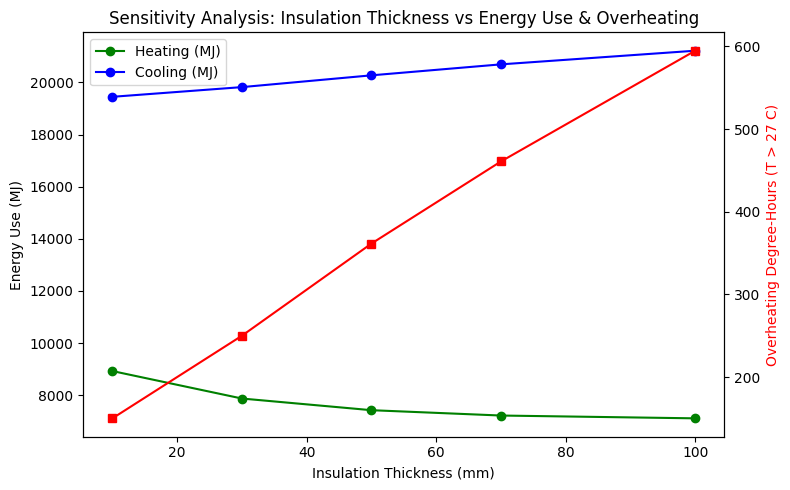

In [40]:
import os
import pandas as pd
import numpy as np
import re

# --- Configuration ---
output_base_dir = r"eppy_output\sensitivity_models"  # Change to your main output folder

# Prepare result storage
results = []

# Loop through each scenario folder
for folder in os.listdir(output_base_dir):
    scenario_path = os.path.join(output_base_dir, folder)
    if not os.path.isdir(scenario_path):
        continue  # Skip non-directory items

    # Define file paths for key outputs
    meter_file = os.path.join(scenario_path, "eplusMeter.csv")
    temp_file = os.path.join(scenario_path, "eplus.csv")

    if not os.path.exists(meter_file) or not os.path.exists(temp_file):
        print(f"Skipping {folder}: Missing required files.")
        continue

    try:
        # --- Read EnergyPlus Meter File ---
        df_meter = pd.read_csv(meter_file)
        
        # Extract total heating and cooling energy from meters
        heating_col = [c for c in df_meter.columns if "HeatingCoils:EnergyTransfer" in c]
        cooling_col = [c for c in df_meter.columns if "CoolingCoils:EnergyTransfer" in c]

        total_heating = df_meter[heating_col].sum().sum() if heating_col else np.nan
        total_cooling = df_meter[cooling_col].sum().sum() if cooling_col else np.nan

        # --- Read Zone Temperature File ---
        df_temp = pd.read_csv(temp_file)

        # Identify temperature and setpoint columns
        zone_temp_col = [c for c in df_temp.columns if "Zone Mean Air Temperature" in c]
        cooling_setpoint_col = [c for c in df_temp.columns if "Zone Thermostat Cooling Setpoint" in c]

        # Calculate overheating degree-hours
        if zone_temp_col and cooling_setpoint_col:
            zone_temp = df_temp[zone_temp_col[0]]
            cooling_setpoint = df_temp[cooling_setpoint_col[0]]
            overheating_degree_hours = np.maximum(zone_temp - cooling_setpoint, 0).sum()
        else:
            overheating_degree_hours = np.nan

        # Extract insulation thickness from folder name using regex
        match = re.search(r"(\d+)mm", folder)
        thickness_mm = int(match.group(1)) if match else None

        # Store results
        results.append({
            "Scenario": folder,
            "Insulation_Thickness_mm": thickness_mm,
            "Total_Heating_Energy_J": total_heating,
            "Total_Cooling_Energy_J": total_cooling,
            "Overheating_Degree_Hours": overheating_degree_hours
        })

    except Exception as e:
        print(f"Error processing {folder}: {e}")

# --- Combine Results into DataFrame ---
df_results = pd.DataFrame(results).sort_values("Insulation_Thickness_mm")
print(df_results)

# --- Save to CSV ---
output_csv = os.path.join(output_base_dir, "sensitivity_analysis_results.csv")
df_results.to_csv(output_csv, index=False)
print(f"Results saved to: {output_csv}")

# --- Plotting ---
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(8, 5))

ax2 = ax1.twinx()
ax1.plot(df_results["Insulation_Thickness_mm"], df_results["Total_Heating_Energy_J"]/1e6, 'g-o', label='Heating (MJ)')
ax1.plot(df_results["Insulation_Thickness_mm"], df_results["Total_Cooling_Energy_J"]/1e6, 'b-o', label='Cooling (MJ)')
ax2.plot(df_results["Insulation_Thickness_mm"], df_results["Overheating_Degree_Hours"], 'r-s', label='Overheating DH')

# Labels and legends
ax1.set_xlabel("Insulation Thickness (mm)")
ax1.set_ylabel("Energy Use (MJ)", color='k')
ax2.set_ylabel("Overheating Degree-Hours (T > 27 C)", color='r')
ax1.legend(loc='upper left')
plt.title("Sensitivity Analysis: Insulation Thickness vs Energy Use & Overheating")
plt.tight_layout()
plt.show()
